<a href="https://colab.research.google.com/github/codeson101001/Stock-Prediction-Models/blob/master/3M_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance
import yfinance as yf
#df = yf.download(tickers="MMM", period="1y", interval="1d")  
df = yf.download("VZ", start="2020-06-10", end="2020-09-10")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=7b57974b24e4d18f6631e0e7820e3de29d018de5e9c0f04fcdf6295a3a45a2d3
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance
[*********************100%***********************]  1 of 1 completed


In [2]:
#This is how I calucalte my short and long window for the moving avg in the future
short_window = int(0.020 * len(df))
long_window = int(0.06 * len(df))

#We are storing the data from the stock information into signals
signals = pd.DataFrame(index = df.index)

#Here we are creating our dataframe column titles
signals['price'] = df['Close']

#We start by seting signals to 0.0 
signals['signal'] = 0.0
signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,price,signal,short_ma,long_ma,positions
Date,,,,,
2020-06-10,58.049999,0.0,58.049999,58.049999,NaN
2020-06-11,56.450001,0.0,56.450001,57.250000,0.0
2020-06-12,56.529999,0.0,56.529999,57.010000,0.0
2020-06-15,56.150002,0.0,56.150002,56.376667,0.0
2020-06-16,56.919998,1.0,56.919998,56.533333,1.0
...,...,...,...,...,...
2020-09-02,60.529999,1.0,60.529999,59.653333,1.0
2020-09-03,60.610001,1.0,60.610001,60.100000,0.0
2020-09-04,60.480000,0.0,60.480000,60.540000,-1.0


In [3]:
#This is the stock simulator
def buy_stock(real_movement, signal, initial_money = 10000, max_buy = 3500, max_sell = 3500,):

    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    #"i" is the day
    #"initial_money" is your money that you started out with
    #"real_movement" is the your money in the stock, which can be larger or smaller that the initial_money 
    def buy(i, initial_money, current_inventory):
        #Here we calualate the number of shares we want to buy using floor division, beucase we can not get pieces of a stock share
        shares = initial_money // real_movement[i]

        if shares < 1:
            print('day %d: total balances %f, not enough money to buy a unit price %f'% (i, initial_money, real_movement[i]))

        else:

            if shares > max_buy:
                buy_units = max_buy

            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print('day %d: buy %d units at price %f, total balance %f'% (i, buy_units, buy_units * real_movement[i], initial_money))
            states_buy.append(0)

        return initial_money, current_inventory



    #This will run for all the dates in in the df 
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]

        if state == 1:
            initial_money, current_inventory = buy(i, initial_money, current_inventory)
            states_buy.append(i)

        elif state == -1:

            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))

            else:
              
                if current_inventory > max_sell:
                    sell_units = max_sell

                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell

                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100

                except:
                    invest = 0
                print('day %d, sell %d units at price %f, investment %f %%, total balance %f,'% (i, sell_units, total_sell, invest, initial_money))

            states_sell.append(i)



    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest


In [4]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 4: buy 175 units at price 9960.999680, total balance 39.000320
day 7, sell 175 units at price 9827.999973, investment -1.335204 %, total balance 9867.000294,
day 13: buy 180 units at price 9844.199753, total balance 22.800541
day 15, sell 180 units at price 9840.599670, investment -0.036571 %, total balance 9863.400211,
day 17: buy 178 units at price 9832.720299, total balance 30.679913
day 20, sell 178 units at price 9601.319756, investment -2.353373 %, total balance 9631.999668,
day 22: buy 176 units at price 9583.200134, total balance 48.799534
day 27, sell 176 units at price 9833.119812, investment 2.607894 %, total balance 9881.919346,
day 30: buy 176 units at price 9829.599731, total balance 52.319614
day 35, sell 176 units at price 10084.799866, investment 2.596241 %, total balance 10137.119480,
day 36: buy 176 units at price 10116.479919, total balance 20.639561
day 37, sell 176 units at price 10074.240295, investment -0.417533 %, total balance 10094.879856,
day 38: buy 174

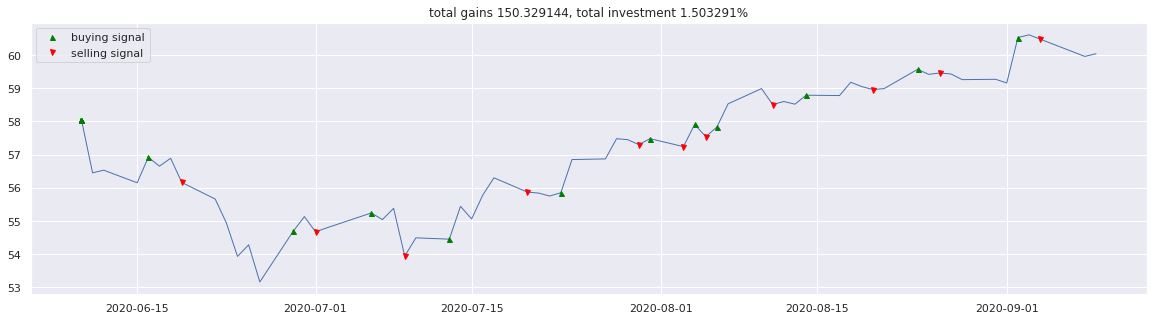

In [5]:
close = df['Close']
fig = plt.figure(figsize = (20,5))

plt.plot(close, color='b', lw=1.)
plt.plot(close, '^', markersize=5, color='green', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=5, color='red', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()